In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from subprocess import run
from thefuzz import process
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)


# Convert docx files to txt
any doc must be converted to docx manually

In [2]:
gen_dir = Path('../data/raw/General')
text_dir = Path('../data/raw_text/General')
text_dir.mkdir(exist_ok=True, parents=True)
output_dir = Path('../data/labeled_text')
output_dir.mkdir(exist_ok=True, parents=True)


In [3]:
docdf = pd.DataFrame()
docdf['doc_path'] = list(gen_dir.glob('*/*.docx'))
docdf.doc_path.apply(lambda x: (text_dir / x.parts[-2]).mkdir(exist_ok=True))
docdf['txt_path'] = docdf.doc_path.apply(lambda x: text_dir / x.parts[-2] / x.parts[-1].replace('.docx','.txt'))

In [4]:
for ix, row in docdf.iterrows():
    if not row.txt_path.exists():
        cmd=f'pandoc -i "{row.doc_path}" -t plain  >  "{row.txt_path}"'
        !{cmd}


In [5]:
docdf['document'] = docdf.doc_path.apply(lambda x: x.parts[-1])
docdf['folder'] = docdf.doc_path.apply(lambda x: x.parts[-2])
docdf['subject'] = docdf.document.str.split(' ').str[0]
docdf['subject'] = docdf.subject.str.replace(',', '')

# Make transcript dataframes

In [6]:
textdfs = []
for ix, row in docdf.iterrows():
    tmptext = row.txt_path.read_text().split('\n\n')

    tmpdf = pd.DataFrame()
    tmpdf['subject'] = [row.subject] * len(tmptext)
    tmpdf['folder'] = [row.folder] * len(tmptext)
    tmpdf['document'] = [row.document] * len(tmptext)
    tmpdf['txt_path'] = [row.txt_path] * len(tmptext)
    tmpdf['line_number'] = range(len(tmptext))
    tmpdf['text'] = tmptext
    textdfs.append(tmpdf)

In [7]:
textdf = pd.concat(textdfs)

# read xlsx and match to transcripts

## Create a df combining all the excel sheets

In [8]:
# Some of the names of documents in the excel sheet don't match the files names
# this look up table has all of the fixes
doc_lut = {
    'BEH2311 T2 Therapist.docx': 'BEH2311 Therapist.docx',
    'BEH2312 T2 Therapist.docx': 'BEH2312 Therapist.docx',
    'BEH2313 T2 Therapist.docx': 'BEH2313 Therapist.docx',
    'BEH2314 T2 Therapist.docx': 'BEH2314 Therapist.docx',
    'BEH2336 T2 Therapist.docx': 'BEH2336 Therapist.docx',
    'BEH2340 T2 Therapist.docx':'BEH2340 Therapist.docx',
    'BEH2314 T2 YP.doc': 'BEH2314 T2 YP.docx',
    'BEH2315 T2 Therapist (002).docx': 'BEH2315 Therapist.docx',
    'BEH2331 T2 T.docx': 'BEH2331 Therapist.docx',
    'BEH2332 T2 Therapist JH Transcription.docx': 'BEH2332 Therapist.docx',
    'BEH2353 therapist.docx': 'BEH2353 Therapist.docx',
    'BEH2360 T2 T.docx': 'BEH2360 Therapist.docx',
    'ISL2203 T2 T.docx': 'ISL2203 Therapist.docx',
    'ISL2209 Therapist T2.docx': 'ISL2209 Therapist.docx',
    'ISL2223 T2 Therapist.docx': 'ISL2223 Therapist.docx',
    'ISL2228, T2, YP.docx': 'ISL2228 T2 YP.docx',
    'TAV2101 T2 Therapist ES Transcript.docx': 'TAV2101 Therapist.docx',
    'TAV2131-T2-YP.docx': 'TAV2131 T2 YP.docx',
    'TAV2145 T2 ES': 'TAV2145 T2 ES.docx',
    'BEH2352.docx': 'BEH2352 Therapist T2.docx',
    'BEH2353 T2 YP SP.docx': 'BEH2353 T2 YP.docx',
    'BEH2360 YP T2 JH.docx': 'BEH2360 T2 YP.docx',
    'ISL2234 T2 Therapist JH.docx': 'ISL2234 Therapist.docx',
    'TAV2117 T2 Parent.doc': 'TAV2117 T2 Parent.docx',
    'TAV2134 T2 Therapist.docx': 'TAV2134 Therapist.docx',
    'TAV2145 T2 P': 'TAV2145 T2 P.docx',
    'TAV2145 T2 YP': 'TAV2145 T2 YP.docx',
}

In [9]:
# one of the quotes has a typo in it compared to the document
# these values 
quote_shim = [
    ('a1_2:5', lambda x: x.replace(' ow much it ', ' how much it '))
]


In [10]:
xl_dir = Path('../data/raw/symptom_change/')
xls = sorted(xl_dir.glob('*.xlsx'))
xls = [xx for xx in xls if '~$' not in xx.as_posix()]
xldfs = []

In [11]:
for xl_path in xls:
    xl = pd.read_excel(xl_path)
    xl['subject'] = xl.Document.str.split().str[0].str.split('.').str[0]
    xl['subject'] = xl.subject.str.replace(',','')
    xl['subject'] = xl.subject.str.split('-').str[0]

    xl['ref_start'] = xl.Reference.str.split(' - ').str[0].astype(int)
    xl['ref_end'] = xl.Reference.str.split(' - ').str[-1].astype(int)
    xl['filename'] = xl_path.parts[-1].split('.')[0]
    xl['code'] = xl_path.parts[-1].split('.')[0].split('_')[0]

    xl['document'] = xl.Document.replace(doc_lut)

    xldfs.append(xl)
xldf = pd.concat(xldfs)

In [12]:
xldf['uid'] = xldf.code + '_' + xldf.ID
# make sure uid is unique
assert xldf.groupby('uid').count().max().max()

In [13]:
for uid, shim_func in quote_shim:
    if (xldf.uid == uid).sum() > 1:
        raise ValueError(f'More than one uid matched {uid}')
    elif (xldf.uid == uid).sum() == 0:
        raise ValueError(f'No uid matched {uid}')
    quote_to_fix = xldf.loc[xldf.uid == uid, 'Quotation Content'].values[0]
    fixed_quote = shim_func(quote_to_fix)
    xldf.loc[xldf.uid == uid, 'Quotation Content'] = fixed_quote

In [14]:
# check for docs that don't match the excel files
for idx, df in xldf.groupby('document'):
    tmpdf = textdf.query("document == @idx")
    if len(tmpdf) == 0:
        print(f"'{idx}': ,")

## First pass
First pass matching just by picking the utterance with the highest score from thefuzz (uses some tokenization and levenshtein distance). Emperically, scores greater than 86 were good matches. I confirmed that matches were good by finding an exact match for the text from the quote in the matched transcript lines. 

In [15]:
matchdf = []
for idx, df in xldf.groupby('document'):
    tmpdf = textdf.query("document == @idx")
    for xlix, xlrow in df.iterrows():
        quote = xlrow['Quotation Content']
        normalized_quote = quote.strip().replace('  ', ' ').replace('  ', ' ')
        matched_text, score, match_index = process.extract(quote, tmpdf.text, limit=1)[0]
        if score <= 86:
            continue
        # need to pull in lines corresponding to additional lines separated by \u2029
        if '\u2029' in quote:
            normalized_quote = normalized_quote.replace(" \u2029", "\u2029").replace("\u2029 ", "\u2029")
            quote_parts = quote.split('\u2029')
            # find the part of the quote that matched originally
            qq_text, qq_score, qq_idx = process.extract(matched_text, pd.Series(quote_parts), limit=1)[0]
            
            qp_idxs = np.arange(len(quote_parts))
            qp_idxs = qp_idxs - qq_idx
            match_indices = match_index + qp_idxs
            full_match = '\u2029'.join(tmpdf.loc[match_indices, 'text'].values)
            quote_in_match = normalized_quote in full_match.replace('\n', ' ').replace('^(th)', 'th')

        else:
            quote_in_match = normalized_quote in matched_text.replace('\n', ' ').replace('^(th)', 'th')
            match_indices = [match_index]
            full_match = matched_text
        
        match_start = match_indices[0]
        match_end = match_indices[-1]
        for mi in match_indices:
            try:
                match_row = dict(
                    subject=xlrow.subject,
                    folder=tmpdf.folder.unique()[0],
                    document=xlrow.document,
                    line_number=mi,
                    uid=xlrow.uid,
                    code=xlrow.code,
                    ID=xlrow.ID,
                    filename=xlrow.filename,
                    transcript_text=tmpdf.loc[mi, 'text'],
                    full_match=full_match,
                    quote=quote,
                    quote_in_match=quote_in_match,
                    xlrefstart = xlrow.ref_start,
                    xlrefend = xlrow.ref_end,
                    matchstart = match_start,
                    matchend = match_end
                )
                if mi == match_index:
                    match_row['score'] = score
                matchdf.append(match_row)
            except KeyError:
                continue

matchdf = pd.DataFrame(matchdf)

In [16]:
matchdf['start_offset'] = (matchdf.xlrefstart - matchdf.matchstart)
matchdf['start_offset_doc_std'] = matchdf.groupby('document').start_offset.transform('std')
matchdf['end_offset'] = (matchdf.xlrefend - matchdf.matchend)

# confirm that start offsets match the end offsets
assert len(matchdf.loc[matchdf.start_offset != matchdf.end_offset]) == 0

In [17]:
# check if offsets are consistent across documents
matchdf.groupby('document')[['start_offset']].std().query('start_offset != 0')

,start_offset
document,
BEH2303 T2 YP.docx,0.455243
ISL2221 Therapist.docx,NaN
ISL2228 T2 Parent.docx,NaN


<Axes: xlabel='line_number', ylabel='start_offset'>

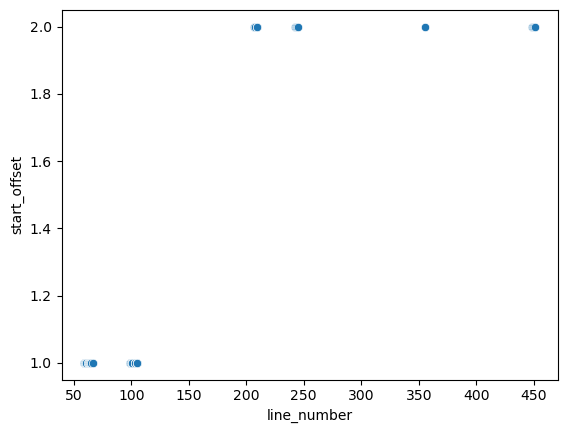

In [18]:
# only one document has a shift, and I checked the entries manually and they seem fine.
sns.scatterplot(x='line_number', y='start_offset', data=matchdf.query('document == "BEH2303 T2 YP.docx"').sort_values(['document', 'line_number']))

In [19]:
# make sure that all of the quotes are verbatim in the matching text
assert matchdf.quote_in_match.all()

In [20]:
merge_tmp = xldf.merge(matchdf, how='outer', on=['document', 'uid', 'code', 'ID', 'subject'], indicator=True)

In [21]:
merge_tmp.groupby('_merge').count()

/var/folders/wz/6yqczlkd3fb3rjn025dydkym0000gs/T/ipykernel_45084/41485191.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merge_tmp.groupby('_merge').count()


,ID,Document,Quotation Content,Reference,subject,ref_start,ref_end,filename_x,code,document,...,quote,quote_in_match,xlrefstart,xlrefend,matchstart,matchend,score,start_offset,start_offset_doc_std,end_offset
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,70,70,70,70,70,70,70,70,70,70,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,3045,3045,3045,3045,3045,3045,3045,3045,3045,3045,...,3045,3045,3045,3045,3045,3045,1042,3045,3043,3045


This approach matches 3045 entries in the excel files and misses 70. So let's see what we can do about that remainder

## Second pass
For each quote, chunk the documents into strings of the length of the quote witha rolling window and look for the best levenshtein match.

In [22]:
docs_missing_matches = merge_tmp.query('_merge == "left_only"').document.unique()

In [23]:
missing = xldf.loc[xldf.uid.isin(merge_tmp.query('_merge == "left_only"').uid.values)]

In [24]:
missing_matches = []
for midx, xlrow in missing.iterrows():
    rowdoc = xlrow.document
    tmpdf = textdf.query("document == @rowdoc").copy()
    tmpdf['dummy'] = tmpdf.apply(lambda x:[x.line_number for cc in x.text] + [x.line_number], axis=1)
    catdoc = '\u2029'.join(tmpdf.text.values)
    doclen = len(catdoc)
    catidxs = []
    for dd in tmpdf.dummy:
        catidxs.extend(dd)
    catidxs = catidxs[:-1]
    quote = xlrow['Quotation Content']
    qlen = len(quote)
    normalized_quote = quote.strip().replace('  ', ' ').replace('  ', ' ')
    if '\u2029' in quote:
        normalized_quote = normalized_quote.replace(" \u2029", "\u2029").replace("\u2029 ", "\u2029")
    
    chunks = {}
    for start_idx in range(0,(doclen-qlen)):
        chunks[start_idx] = catdoc[start_idx:start_idx + qlen]
    matched_text, score, match_index = process.extract(normalized_quote, chunks, limit=1)[0]
    match_indices = np.unique(catidxs[match_index:match_index+qlen])

    match_start = match_indices[0]
    match_end = match_indices[-1]
    quote_in_match = normalized_quote[3:-3] in matched_text.replace('\n', ' ').replace('^(th)', 'th').strip('.').strip()
    for mi in match_indices:
        match_row = dict(
            subject=xlrow.subject,
            folder=tmpdf.folder.unique()[0],
            document=xlrow.document,
            line_number=mi,
            uid=xlrow.uid,
            code=xlrow.code,
            ID=xlrow.ID,
            filename=xlrow.filename,
            transcript_text=tmpdf.loc[mi, 'text'],
            full_match=matched_text,
            quote=quote,
            quote_in_match=quote_in_match,
            xlrefstart=xlrow.ref_start,
            xlrefend=xlrow.ref_end,
            matchstart=match_start,
            matchend=match_end,
            score=score
        )
    missing_matches.append(match_row)
    

In [25]:
missing_matches = pd.DataFrame(missing_matches)

In [26]:
# confirm that all the missing matches have a verbatim match
assert len(missing_matches.query('not quote_in_match')) == 0

In [27]:
missing_matches.score.min()

100

In [28]:
matchdf['pass'] = 'first'
missing_matches['pass'] = 'second'

In [29]:
matchdf = pd.concat([matchdf, missing_matches])

In [30]:
merge_tmp = xldf.merge(matchdf, how='outer', on=['document', 'uid', 'code', 'ID', 'subject', 'filename'], indicator=True)

In [31]:
merge_tmp.groupby('_merge').count()

/var/folders/wz/6yqczlkd3fb3rjn025dydkym0000gs/T/ipykernel_45084/41485191.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merge_tmp.groupby('_merge').count()


,ID,Document,Quotation Content,Reference,subject,ref_start,ref_end,filename,code,document,...,quote_in_match,xlrefstart,xlrefend,matchstart,matchend,score,start_offset,start_offset_doc_std,end_offset,pass
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,3115,3115,3115,3115,3115,3115,3115,3115,3115,3115,...,3115,3115,3115,3115,3115,1112,3045,3043,3045,3115


In [32]:
merge_tmp.to_excel(output_dir / 'merged_labels_and_text.xlsx')

All of the excel entries have a transcript match now.

## postprocess matches
find the longest utterance that matches a chunk of the quote

In [33]:
# # this bert stuff is probably a bit of a nerd snipe
# from transformers import BertTokenizer, BertModel
# from scipy.spatial.distance import cosine

# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = BertModel.from_pretrained("bert-base-cased")


# chunkdf = []
# for uid, df in merge_tmp.loc[merge_tmp.quote.str.contains('\u2029')].groupby("uid"):

#     quote = df.quote.iloc[0]
#     quote_tokens = tokenizer(quote, return_tensors='pt', truncation=True)
#     quote_ntokens = len(quote_tokens['input_ids'][0])
#     quote_embed = model(**quote_tokens)[1].detach().numpy()
#     for stepsize in range(1, len(df)):
#         for start in range(0, len(df) - stepsize + 1):
#             text= '\n'.join(df.transcript_text.iloc[start:start+stepsize])
#             line_tokens = tokenizer(text, return_tensors='pt', truncation=True)
#             line_ntokens = len(line_tokens['input_ids'][0])
#             line_embed = model(**line_tokens)[1].detach().numpy()
#             dist = cosine(quote_embed[0], line_embed[0])
#             row = dict(
#                 uid=uid,
#                 stepsize=stepsize,
#                 start=start,
#                 end=start+stepsize,
#                 text=text,
#                 dist=dist,
#                 logdis=-np.log10(dist),
#                 nlines=len(df),
#                 quote_ntokens=quote_ntokens,
#                 line_ntokens=line_ntokens
#             )
#             chunkdf.append(row)
# chunkdf = pd.DataFrame(chunkdf)

# chunkdf['nlines'] =  chunkdf.groupby("uid").end.transform('max')
# chunkdf['weighted_score'] = chunkdf.logdist * (chunkdf.nlines / chunkdf.stepsize)
# chunkdf['nlineembeds'] = chunkdf.groupby("uid").stepsize.transform('count')

# chunkdf.groupby('uid').nlines.first().reset_index().groupby('nlines').count()

# chunkdf.to_excel(output_dir / 'semantic_eval.xlsx')

# chunkdf.query('nlines > 2 & nlines < 9').groupby(['uid', 'stepsize']).logdist.max().reset_index().groupby('stepsize').logdist.describe()

In [34]:
def get_biggest_quote_chunk(quote):
    qparts = np.array(quote.split('\u2029'))
    qplen = np.array([len(qp) for qp in qparts])
    return qparts[qplen == qplen.max()][0]

In [35]:
merge_tmp['biggest_quote_chunk'] = merge_tmp.quote.apply(get_biggest_quote_chunk)

In [36]:
def find_transcript_match(df):
    match, score, line_number = process.extract(df.biggest_quote_chunk.values[0], df.set_index('line_number').transcript_text, limit=1)[0]
    return line_number

In [37]:
tmatch = pd.DataFrame(merge_tmp.groupby('uid').apply(find_transcript_match, include_groups=False), columns=['transcript_match_to_biggest_quote_chunk']).reset_index()
merge_tmp = merge_tmp.merge(tmatch, how='left', on='uid')

In [38]:
merge_tmp['p_in_transcript'] = merge_tmp.transcript_text.str.lower().str.contains('p:')
merge_tmp['i_in_transcript'] = merge_tmp.transcript_text.str.lower().str.contains('i:')

In [39]:
merge_tmp['qlen'] = merge_tmp.quote.apply(lambda x: len(x))
merge_tmp.groupby('code').qlen.describe()

,count,mean,std,min,25%,50%,75%,max
code,,,,,,,,
a1,317.0,595.747634,383.631126,41.0,295.00,480.0,855.00,1578.0
a2,141.0,707.992908,436.640887,93.0,424.00,628.0,876.00,2922.0
a3,42.0,763.761905,589.573174,155.0,462.00,515.0,676.00,2222.0
a4,86.0,766.186047,343.301360,109.0,492.00,871.0,1035.00,1589.0
a5,42.0,661.952381,432.419396,109.0,202.25,732.0,1128.00,1128.0
a6,36.0,556.388889,342.970243,128.0,218.00,670.5,764.00,1800.0
a7,63.0,717.777778,830.623385,239.0,292.00,421.0,644.00,4216.0
a8,12.0,869.833333,787.185762,172.0,172.00,602.0,1310.00,2222.0
b1,113.0,850.070796,330.737048,212.0,595.00,855.0,1234.00,1342.0


# Merge results in with transcript text

In [40]:
matched_lines = merge_tmp.loc[:, ['uid', 'code', 'subject', 'folder', 'document', 'line_number', 'transcript_match_to_biggest_quote_chunk', 'transcript_text']]
matched_lines = matched_lines.rename(columns = {'transcript_text':'text'})

In [41]:
merge_tmp['line_uid'] = merge_tmp.apply(lambda x :f"{x.document}_{x.line_number:05d}", axis=1)
textdf['line_uid'] = textdf.apply(lambda x :f"{x.document}_{x.line_number:05d}", axis=1)

In [42]:
test = textdf.merge(matched_lines, how='outer', on=['subject', 'folder', 'document', 'line_number', 'text'], indicator=True)
assert len(test.query('_merge == "right_only"')) == 0
merged_text = textdf.merge(matched_lines, how='outer', on=['subject', 'folder', 'document', 'line_number', 'text'], indicator=False)
text_with_match = merged_text.query('uid.notnull()')
text_no_match = merged_text.query('uid.isnull()')

codes = sorted(text_with_match.code.unique())

In [43]:
all_dir = output_dir / 'all'
all_dir.mkdir(exist_ok=True)

ptnoshort_dir = output_dir / 'pt_noshort'
ptnoshort_dir.mkdir(exist_ok=True)

turns_dir = output_dir / 'turns'
turns_dir.mkdir(exist_ok=True)

In [44]:
lines_to_drop = [
    # these lines are just parentheticals that can be dropped
    'BEH2339 T2 YP JH.docx_00138',
    'BEH2339 T2 Parent.docx_00292',
    'TAV2131 T2 Therapist.docx_00053',
    'BEH2311 T2 Parent.docx_00380',
    'TAV2101 T2 Parent.docx_00011',
    'TAV2101 T2 Parent.docx_00016',
    'BEH2311 T2 Parent.docx_00359',
    'ISL2203 T2 Parent.docx_00236',
    'TAV2117 T2 Parent.docx_00320',
    'TAV2101 Therapist.docx_00021',
    'BEH2339 T2 YP JH.docx_00093',
    'BEH2339 T2 YP JH.docx_00201',
    'ISL2209 Therapist.docx_00123',
    'ISL2209 T2 Parent.docx_00076',
    'BEH2303 T2 YP.docx_00017',
    # These are all a father interjecting in the conversation about a side topic and can be dropped
    'BEH2303 T2 YP.docx_00017',
    'BEH2303 T2 YP.docx_00070',
    'BEH2303 T2 YP.docx_00072',
    'BEH2303 T2 YP.docx_00074',
    'BEH2303 T2 YP.docx_00076',
    'BEH2303 T2 YP.docx_00078',
    'BEH2303 T2 YP.docx_00080',
    'BEH2303 T2 YP.docx_00082',
    'BEH2303 T2 YP.docx_00084',
    'BEH2303 T2 YP.docx_00086',
    'BEH2303 T2 YP.docx_00088',
    'BEH2303 T2 YP.docx_00094',
    'BEH2303 T2 YP.docx_00096',
    'BEH2303 T2 YP.docx_00228',
    'BEH2303 T2 YP.docx_00230',
    'BEH2303 T2 YP.docx_00252',
    'BEH2303 T2 YP.docx_00255',
    'BEH2303 T2 YP.docx_00257',
    'BEH2303 T2 YP.docx_00259',
    # lines that just say end of interview:
    'BEH2311 T2 YP.docx_00198',
    'ISL2203 T2 Parent.docx_00239',
    'ISL2209 Therapist.docx_00122',
    # useless bits that are just easier to drop than to deal with:
    'TAV2134 T2 P.docx_00447',
    'BEH2336 T2 Parent.docx_00113',
    'BEH2332 Therapist.docx_00134',
    'TAV2101 Therapist.docx_00018',
    'TAV2101 Therapist.docx_00057',
    'TAV2145 T2 ES.docx_00003',
    'TAV2117 T2 Parent.docx_00205',
    'BEH2340 T2 Parent.docx_00138',
    'BEH2340 T2 Parent.docx_00140',
    'TAV2101 T2 YP.docx_00188',
    'TAV2101 T2 YP.docx_00220'
    ]

In [45]:
domains = ['a', 'b','c', 'd', 'e', 'f', 'g']

In [46]:
all_lens = []
turn_lens = []
ptnoshort_lens = []
for code in codes + domains + ['all']:

    to_write = merged_text.copy()
    to_write['positive'] = False
    if code in codes:
        to_write.loc[to_write.code == code, 'positive'] = True
    elif code in domains:
        for cc in codes:
            if code in cc:
                to_write.loc[to_write.code == code, 'positive'] = True
    elif code == 'all':
        to_write.loc[to_write.code.notnull(), 'positive'] = True
    
    to_write = to_write.rename(columns={'folder':'reporter', 'line_uid': 'line_id'}).sort_values(['subject','reporter', 'line_number'])
    
    drop_ind = (
        to_write.text.str.lower().str.contains('age:')
        | to_write.text.str.lower().str.contains('gender:')
        | to_write.text.str.lower().str.contains('interviewer:')
        | to_write.text.str.lower().str.contains('pseudonym:')
        | to_write.text.str.lower().str.contains('time point:')
        | to_write.line_id.isin(lines_to_drop)
    )

    okprefixes = ['I:', 'P:', 'P1', 'P2', 'I2', 'P3']
    
    to_write['prefix'] = to_write.text.str.strip().str[:2].str.strip()
    to_write.loc[to_write.text.str.strip().str[:7].str.lower() == 'mother:', 'prefix'] = 'P1'
    to_write.loc[to_write.text.str.strip().str[:7].str.lower() == 'father:', 'prefix'] = 'P2'
    to_write.loc[to_write.text.str.strip().str[:10].str.lower() == 'therapist:', 'prefix'] = 'I:'
    to_write.loc[to_write.text.str.strip().str[:11].str.lower() == 'adolescent:', 'prefix'] = 'P3'
    to_write.loc[to_write.text.str.strip().str[:6].str.lower() == 'child:', 'prefix'] = 'P3'
    to_write.loc[to_write.text.str.strip().str[:17].str.lower() == 'younger daughter:', 'prefix'] = 'P3'

    #actually going to overwrite text so that length filters work
    to_write.loc[to_write.text.str.strip().str[:7].str.lower() == 'mother:', 'text'] = 'P1:' + to_write.loc[to_write.text.str.strip().str[:7].str.lower() == 'mother:', 'text'].str[7:]
    to_write.loc[to_write.text.str.strip().str[:7].str.lower() == 'father:', 'text'] = 'P2:' + to_write.loc[to_write.text.str.strip().str[:7].str.lower() == 'father:', 'text'].str[7:]
    to_write.loc[to_write.text.str.strip().str[:10].str.lower() == 'therapist:', 'text'] = 'I:'  + to_write.loc[to_write.text.str.strip().str[:10].str.lower() == 'therapist:', 'text'].str[10:]
    to_write.loc[to_write.text.str.strip().str[:11].str.lower() == 'adolescent:', 'text'] = 'P3:' + to_write.loc[to_write.text.str.strip().str[:11].str.lower() == 'adolescent:', 'text'].str[11:]
    to_write.loc[to_write.text.str.strip().str[:6].str.lower() == 'child:', 'text'] = 'P3:' + to_write.loc[to_write.text.str.strip().str[:6].str.lower() == 'child:', 'text'].str[6:]
    to_write.loc[to_write.text.str.strip().str[:17].str.lower() == 'younger daughter:', 'text'] = 'P3:' + to_write.loc[to_write.text.str.strip().str[:17].str.lower() == 'younger daughter:', 'text'].str[17:]
    
    prefix_fixes = [
        ('BEH2311 T2 Parent.docx_00379', 'P:'),
        ('BEH2314 T2 (P).docx_00065', 'P:'),
        ('ISL2203 T2 Parent.docx_00067', 'P:'),
        ('ISL2203 T2 Parent.docx_00169', 'P:'),
        ('ISL2228 T2 YP.docx_00057', 'P:'),
        ('ISL2228 T2 YP.docx_00092', 'P:'),
        ('ISL2228 T2 YP.docx_00099', 'P:'),
        ('ISL2228 T2 YP.docx_00110', 'P:'),
        ('ISL2228 T2 YP.docx_00207', 'P:'),
        ('TAV2101 T2 Parent.docx_00027', 'P:'),
        ('TAV2131 T2 Therapist.docx_00054', 'P:'),
        ('BEH2340 Therapist.docx_00063', 'P:')
    ]
    for lineid, prefix in prefix_fixes:
        to_write.loc[to_write.line_id == lineid, 'prefix'] = prefix
        to_write.loc[to_write.line_id == lineid, 'text'] = prefix + ' ' + to_write.loc[to_write.line_id == lineid, 'text'].values[0]
    to_write['okprefix'] = to_write.prefix.isin(okprefixes)
    
    # cleaning prefixes around timestamps
    to_write.loc[~drop_ind & ~to_write.okprefix & to_write.prefix.str.contains('\(') & to_write.text.str[6:15].str.contains('P:'), 'prefix'] = 'P:'
    to_write.loc[~drop_ind & ~to_write.okprefix & to_write.prefix.str.contains('\(') & to_write.text.str[6:15].str.contains('I:'), 'prefix'] = 'I:'
    to_write['okprefix'] = to_write.prefix.isin(okprefixes)
    
    # make sure everything has an ok prefix after fixes
    assert len(to_write.loc[~drop_ind & ~to_write.okprefix ]) == 0
    # make sure that none of the dropped things are code matches
    assert(to_write.loc[drop_ind, 'uid'].notnull().sum() == 0)

    to_write['old_reporter'] = to_write.reporter
    to_write['reporter'] = to_write.old_reporter.replace({'Adolescent': 'y', 'Parent':'p', 'Therapist':'t'})
    to_write['text'] = to_write.text.str.replace('\n', ' ')
    # Use the below to manually check that the first line from each document is meaningfull 
    #to_write.loc[~drop_ind].groupby('document').first()
    to_write = to_write.loc[~drop_ind].copy()
    # drop duplicated lines
    ## first got to make sure that if any of a line is positive, they all are
    to_write['positive'] = to_write.groupby('line_id').positive.transform('any')
    to_write = to_write.loc[~to_write.line_id.duplicated()].copy()

    # assign turn_ids
    turn_ids = []
    for document, df in to_write.groupby('document'):
        tid = 0
        for ix, row in df.reset_index(drop=True).iterrows():
            if (ix != 0) and ('I' in row.prefix):
                tid += 1
            
            trow = dict(
                line_id=row.line_id,
                turn_id=f'{row.document}_{tid:04d}'
            )
            turn_ids.append(trow)
    turn_ids = pd.DataFrame(turn_ids)
    
    tmp = to_write.merge(turn_ids, how='outer', on='line_id', indicator=True)
    assert len(tmp.query("_merge != 'both'")) == 0
    to_write = to_write.merge(turn_ids, how='outer', on='line_id')
    alltext = to_write.loc[:, ['line_id', 'subject', 'reporter', 'text', 'positive']]
    
    if alltext.text.str.contains('\t').sum() > 0:
        raise ValueError("Text contains a tab, formatting's gonna get broken.")
    if alltext.text.str.contains('\n').sum() > 0:
        raise ValueError("Text contains a newline, formatting's gonna get broken.")
    all_filename = all_dir / f'{code}.tsv'
    alltext.to_csv(all_filename, sep='\t', index=None)
    all_lens.append(len(alltext))
    
    turns = to_write.groupby('turn_id')[['subject', 'reporter']].first()
    turns['text'] = to_write.groupby('turn_id').text.apply(lambda x:' '.join(x))
    turns['positive'] = to_write.groupby('turn_id').positive.any()
    turns = turns.reset_index()

    if turns.text.str.contains('\t').sum() > 0:
        raise ValueError("Text contains a tab, formatting's gonna get broken.")
    if turns.text.str.contains('\n').sum() > 0:
        raise ValueError("Text contains a newline, formatting's gonna get broken.")
    turns_filename = turns_dir / f'{code}.tsv'
    turns.loc[:, ['turn_id', 'subject', 'reporter', 'text', 'positive']].to_csv(turns_filename, sep='\t', index=None)
    turn_lens.append(len(turns))
    
    fornoshort = to_write.loc[~to_write.prefix.str.contains('I')]
    ptnoshort = fornoshort.groupby('turn_id')[['subject', 'reporter']].first()
    ptnoshort['text'] = fornoshort.groupby('turn_id').text.apply(lambda x:' '.join(x))
    ptnoshort['positive'] = fornoshort.groupby('turn_id').positive.any()
    ptnoshort = ptnoshort.loc[(ptnoshort.text.apply(lambda x: len(x)) > 12)].copy()
    # I reviewed the 100 shortest positive utterances longer than 12 characters
    # and found some we should drop
    uninformative_texts = [
    'P: chose one\u2026',
    'P: Yeah, yep.',
    'P: and\u2026 yeah\u2026',
    'P: Yeah true\u2026',
    'P: Yeah, yeah.',
    'P: (inaudible)',
    'P: Yep, yep...',
    "P: I'd say yes\u2026",
    'P: For (child)?',
    'P: yeah-yeah...',
    'P: not angry...',
    'P: than she had\u2026',
    'P: And you know,',
    'P: Yeah, yeah...',
    'P: yeah coz you\u2026',
    'P: 2 years ago...',
    'P: No, not really',
    'P: Much better...',
    'P: Mmm definitely',
    'P: Definitely not.',
    "P: I don’t know...",
    'P: Yeah and he was//',
    'P: I think kind of...',
    'P: sort of regularly\u2026',
    'P: Mm definitely yeah.',
    "P: hmm I'm not sure...",
    'P: hmmm maybe like two\u2026',
    'P: Yes that’s what it is.',
    'P: Yes (I: Right) I think so.',
    'P: and was able to hold onto\u2026',
    'P: erm... not what did you say...',
    'P: Yess. That’s right. Yess, yeah.',
    'P: er... erm... I dunno... just I dunno...',
]
    ptnoshort = ptnoshort.loc[~ptnoshort.text.isin(uninformative_texts)].copy()
    ptnoshort = ptnoshort.reset_index()
    if ptnoshort.text.str.contains('\t').sum() > 0:
        raise ValueError("Text contains a tab, formatting's gonna get broken.")
    if ptnoshort.text.str.contains('\n').sum() > 0:
        raise ValueError("Text contains a newline, formatting's gonna get broken.")
    ptnoshort_filename = ptnoshort_dir / f'{code}.tsv'
    ptnoshort.loc[:, ['turn_id', 'subject', 'reporter', 'text', 'positive']].to_csv(ptnoshort_filename, sep='\t', index=None)
    ptnoshort_lens.append(len(ptnoshort))


    

<>:66: SyntaxWarning: invalid escape sequence '\('
<>:67: SyntaxWarning: invalid escape sequence '\('
<>:66: SyntaxWarning: invalid escape sequence '\('
<>:67: SyntaxWarning: invalid escape sequence '\('
/var/folders/wz/6yqczlkd3fb3rjn025dydkym0000gs/T/ipykernel_45084/67012122.py:66: SyntaxWarning: invalid escape sequence '\('
  to_write.loc[~drop_ind & ~to_write.okprefix & to_write.prefix.str.contains('\(') & to_write.text.str[6:15].str.contains('P:'), 'prefix'] = 'P:'
/var/folders/wz/6yqczlkd3fb3rjn025dydkym0000gs/T/ipykernel_45084/67012122.py:67: SyntaxWarning: invalid escape sequence '\('
  to_write.loc[~drop_ind & ~to_write.okprefix & to_write.prefix.str.contains('\(') & to_write.text.str[6:15].str.contains('I:'), 'prefix'] = 'I:'


In [47]:
assert np.std(all_lens) == 0
assert np.std(turn_lens) == 0
assert np.std(ptnoshort_lens) == 0